In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
file_path = '/content/drive/My Drive/Colab Notebooks/dl-albanian/AlbAna-simplified.csv'

# Load the CSV file into a DataFrame
df = pd.read_csv(file_path, header=0)

In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [4]:
#Create lists of Annotations and Comments
y = df['Annotation']
docs = df['Comment']

In [5]:
# Train-test split
x_train, x_test, y_train, y_test = train_test_split(docs, y, test_size=0.3, random_state=1000)

In [6]:
# Tokenization with Bert
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
train_inputs = tokenizer(x_train.tolist(), padding=True, truncation=True, return_tensors="pt")
test_inputs = tokenizer(x_test.tolist(), padding=True, truncation=True, return_tensors="pt")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [8]:
# Model: mBERT
from transformers import BertForSequenceClassification
num_labels = len(y.unique())
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=num_labels)

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# Fine-tuning parameters
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

In [10]:
# Convert labels to tensor
train_labels = torch.tensor(y_train.tolist())
test_labels = torch.tensor(y_test.tolist())

In [11]:
# Create DataLoader for training and testing
train_dataset = TensorDataset(train_inputs.input_ids, train_inputs.attention_mask, train_labels)
test_dataset = TensorDataset(test_inputs.input_ids, test_inputs.attention_mask, test_labels)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [12]:
# Fine-tuning
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.train()
for epoch in range(3):  # can adjust the number of epochs here
    total_loss = 0
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Average Loss: {total_loss/len(train_loader)}")

# Save the fine-tuned model
model.save_pretrained("/content/drive/My Drive/Colab Notebooks/dl-albanian/xlm-model")

Epoch 1, Average Loss: 0.7611074875802436
Epoch 2, Average Loss: 0.5577449357573022
Epoch 3, Average Loss: 0.42276179506740674


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


Accuracy: 0.7263419174681973
              precision    recall  f1-score   support

           0       0.83      0.73      0.77      1837
           1       0.69      0.72      0.70       507
           2       0.59      0.73      0.66       879

    accuracy                           0.73      3223
   macro avg       0.70      0.72      0.71      3223
weighted avg       0.74      0.73      0.73      3223

Confusion matrix, without normalization


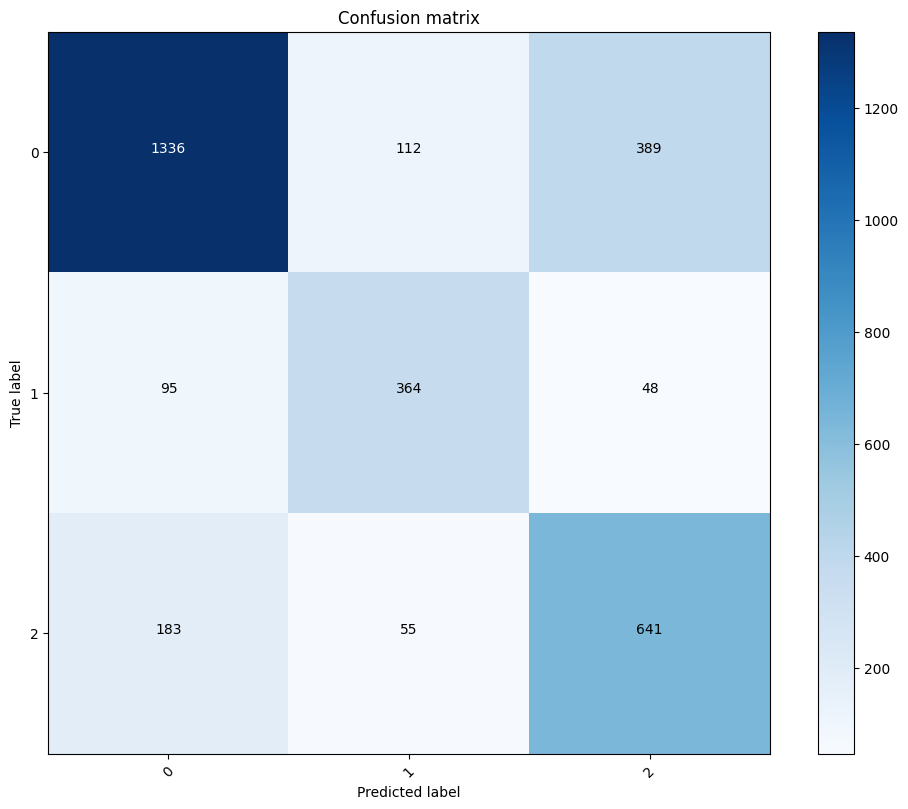

In [14]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import itertools

# Set model to evaluation mode
model.eval()

# Initialize lists to store predictions and true labels
all_preds = []
all_labels = []

# Iterate over the test loader
for batch in test_loader:
    input_ids, attention_mask, labels = batch
    input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

    # Forward pass
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    # Predictions
    preds = logits.argmax(dim=1)

    # Append predictions and true labels to lists
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

# accuracy
accuracy = accuracy_score(all_labels, all_preds)
print("Accuracy:", accuracy)

# other metrics
print(classification_report(all_labels, all_preds))

# confusion matrix
cnf_matrix = confusion_matrix(all_labels, all_preds)
classes = ['0', '1', '2']
plot_confusion_matrix(cnf_matrix, classes=classes)
